In [ ]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim

# Define the neural network
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(4, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 3)  # outputs: u, v, w
        )

    def forward(self, x):
        return self.model(x)

# Residual function for the 3D Burgers' equation
def burgers_pde_residual(model, x, y, z, t, nu):
    X = torch.cat([x, y, z, t], dim=1).requires_grad_(True)
    u = model(X)

    u1 = u[:, 0:1]
    u2 = u[:, 1:2]
    u3 = u[:, 2:3]

    grads = autograd.grad(u, X, torch.ones_like(u), create_graph=True)[0]
    u1_x, u1_y, u1_z, u1_t = grads[:, 0:1], grads[:, 1:2], grads[:, 2:3], grads[:, 3:4]
    u2_x, u2_y, u2_z, u2_t = grads[:, 0:1], grads[:, 1:2], grads[:, 2:3], grads[:, 3:4]
    u3_x, u3_y, u3_z, u3_t = grads[:, 0:1], grads[:, 1:2], grads[:, 2:3], grads[:, 3:4]

    u1_xx = autograd.grad(u1_x, X, torch.ones_like(u1_x), create_graph=True)[0][:, 0:1]
    u1_yy = autograd.grad(u1_y, X, torch.ones_like(u1_y), create_graph=True)[0][:, 1:2]
    u1_zz = autograd.grad(u1_z, X, torch.ones_like(u1_z), create_graph=True)[0][:, 2:3]

    u2_xx = autograd.grad(u2_x, X, torch.ones_like(u2_x), create_graph=True)[0][:, 0:1]
    u2_yy = autograd.grad(u2_y, X, torch.ones_like(u2_y), create_graph=True)[0][:, 1:2]
    u2_zz = autograd.grad(u2_z, X, torch.ones_like(u2_z), create_graph=True)[0][:, 2:3]

    u3_xx = autograd.grad(u3_x, X, torch.ones_like(u3_x), create_graph=True)[0][:, 0:1]
    u3_yy = autograd.grad(u3_y, X, torch.ones_like(u3_y), create_graph=True)[0][:, 1:2]
    u3_zz = autograd.grad(u3_z, X, torch.ones_like(u3_z), create_graph=True)[0][:, 2:3]

    # Burgers' equation residuals
    res_u = u1_t + u1 * u1_x + u2 * u1_y + u3 * u1_z - nu * (u1_xx + u1_yy + u1_zz)
    res_v = u2_t + u1 * u2_x + u2 * u2_y + u3 * u2_z - nu * (u2_xx + u2_yy + u2_zz)
    res_w = u3_t + u1 * u3_x + u2 * u3_y + u3 * u3_z - nu * (u3_xx + u3_yy + u3_zz)

    return res_u, res_v, res_w

# Sample collocation points (for PDE loss)
def generate_collocation_points(N):
    x = torch.rand(N, 1)
    y = torch.rand(N, 1)
    z = torch.rand(N, 1)
    t = torch.rand(N, 1)
    return x, y, z, t

# Sample initial conditions: u(0,x,y,z) = 0
def generate_initial_conditions(N):
    x = torch.rand(N, 1)
    y = torch.rand(N, 1)
    z = torch.rand(N, 1)
    t = torch.zeros_like(x)
    u = torch.zeros(N, 3)
    return torch.cat([x, y, z, t], dim=1), u

# Sample boundary conditions (for simplicity, zero Dirichlet everywhere)
def generate_boundary_conditions(N):
    t = torch.rand(N, 1)
    zeros = torch.zeros_like(t)
    ones = torch.ones_like(t)

    bc_list = []
    for coord in [0.0, 1.0]:
        for axis in range(3):
            point = torch.rand(N, 4)
            point[:, axis] = coord
            bc_list.append(point)
    x = torch.cat(bc_list, dim=0)
    u = torch.zeros_like(x[:, :3])
    return x, u

# Training setup
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
nu = 0.01
epochs = 5000

# Training loop
for epoch in range(epochs):
    model.train()

    # Residual loss
    x, y, z, t = generate_collocation_points(10000)
    res_u, res_v, res_w = burgers_pde_residual(model, x, y, z, t, nu)
    loss_pde = torch.mean(res_u**2 + res_v**2 + res_w**2)

    # Initial condition loss
    x_ic, u_ic = generate_initial_conditions(1000)
    pred_ic = model(x_ic)
    loss_ic = torch.mean((pred_ic - u_ic)**2)

    # Boundary condition loss
    x_bc, u_bc = generate_boundary_conditions(1000)
    pred_bc = model(x_bc)
    loss_bc = torch.mean((pred_bc - u_bc)**2)

    loss = loss_pde + loss_ic + loss_bc

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}, PDE: {loss_pde.item():.6f}, IC: {loss_ic.item():.6f}, BC: {loss_bc.item():.6f}")

print("Training complete.")


Epoch 0, Loss: 0.012595, PDE: 0.001035, IC: 0.006326, BC: 0.005233
Epoch 500, Loss: 0.000004, PDE: 0.000000, IC: 0.000001, BC: 0.000002
Epoch 1000, Loss: 0.000001, PDE: 0.000000, IC: 0.000000, BC: 0.000001
Epoch 1500, Loss: 0.000001, PDE: 0.000000, IC: 0.000000, BC: 0.000000
Epoch 2000, Loss: 0.000001, PDE: 0.000000, IC: 0.000000, BC: 0.000000
Epoch 2500, Loss: 0.000000, PDE: 0.000000, IC: 0.000000, BC: 0.000000
Epoch 3000, Loss: 0.000001, PDE: 0.000001, IC: 0.000000, BC: 0.000000
Epoch 3500, Loss: 0.000001, PDE: 0.000000, IC: 0.000000, BC: 0.000000
Epoch 4000, Loss: 0.000000, PDE: 0.000000, IC: 0.000000, BC: 0.000000
Epoch 4500, Loss: 0.000001, PDE: 0.000000, IC: 0.000000, BC: 0.000000
Training complete.


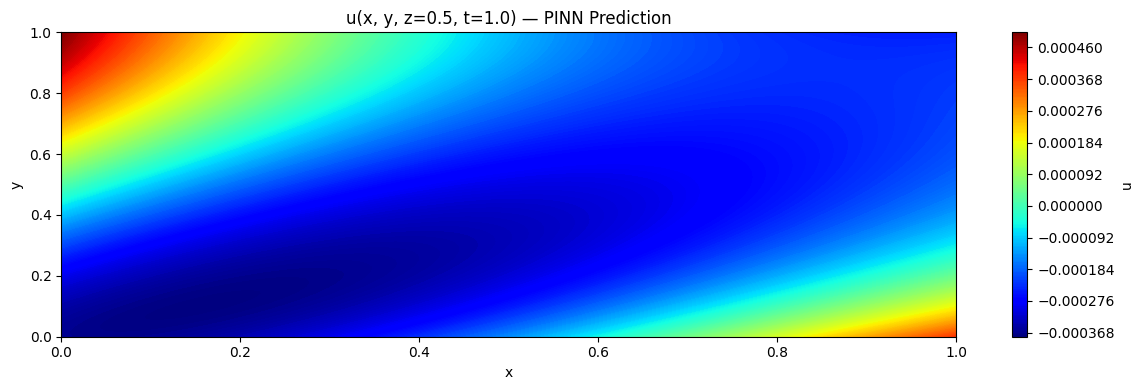

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Create a grid for x and y, fix z and t
x = torch.linspace(0, 1, 100)
y = torch.linspace(0, 1, 100)
x, y = torch.meshgrid(x, y, indexing='xy')

# Fixed values
z_val = 0.5
t_val = 1.0

# Flatten and create input tensor
x_flat = x.reshape(-1, 1)
y_flat = y.reshape(-1, 1)
z_flat = torch.full_like(x_flat, z_val)
t_flat = torch.full_like(x_flat, t_val)

X_test = torch.cat([x_flat, y_flat, z_flat, t_flat], dim=1)

# Evaluate model
model.eval()
with torch.no_grad():
    u_pred = model(X_test).numpy()

# Extract u, v, w components
u = u_pred[:, 0].reshape(100, 100)
v = u_pred[:, 1].reshape(100, 100)
w = u_pred[:, 2].reshape(100, 100)

# Plotting u(x, y) at z=0.5 and t=1.0
plt.figure(figsize=(12, 4))
plt.contourf(x.numpy(), y.numpy(), u, levels=250, cmap='jet')
plt.colorbar(label='u')
plt.xlabel('x')
plt.ylabel('y')
plt.title('u(x, y, z=0.5, t=1.0) — PINN Prediction')
plt.tight_layout()
plt.show()


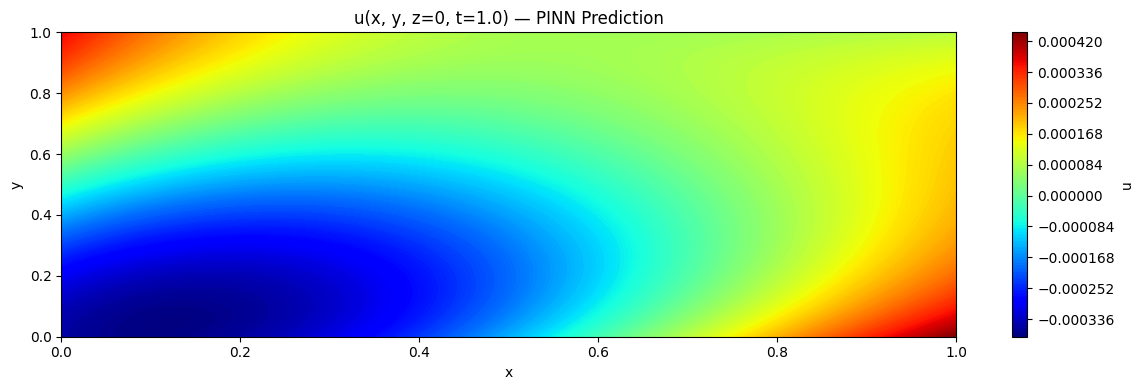

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Create a grid for x and y, fix z and t
x = torch.linspace(0, 1, 100)
y = torch.linspace(0, 1, 100)
x, y = torch.meshgrid(x, y, indexing='xy')

# Fixed values
z_val = 0
t_val = 1.0

# Flatten and create input tensor
x_flat = x.reshape(-1, 1)
y_flat = y.reshape(-1, 1)
z_flat = torch.full_like(x_flat, z_val)
t_flat = torch.full_like(x_flat, t_val)

X_test = torch.cat([x_flat, y_flat, z_flat, t_flat], dim=1)

# Evaluate model
model.eval()
with torch.no_grad():
    u_pred = model(X_test).numpy()

# Extract u, v, w components
u = u_pred[:, 0].reshape(100, 100)
v = u_pred[:, 1].reshape(100, 100)
w = u_pred[:, 2].reshape(100, 100)

# Plotting u(x, y) at z=0.5 and t=1.0
plt.figure(figsize=(12, 4))
plt.contourf(x.numpy(), y.numpy(), u, levels=250, cmap='jet')
plt.colorbar(label='u')
plt.xlabel('x')
plt.ylabel('y')
plt.title('u(x, y, z=0, t=1.0) — PINN Prediction')
plt.tight_layout()
plt.show()


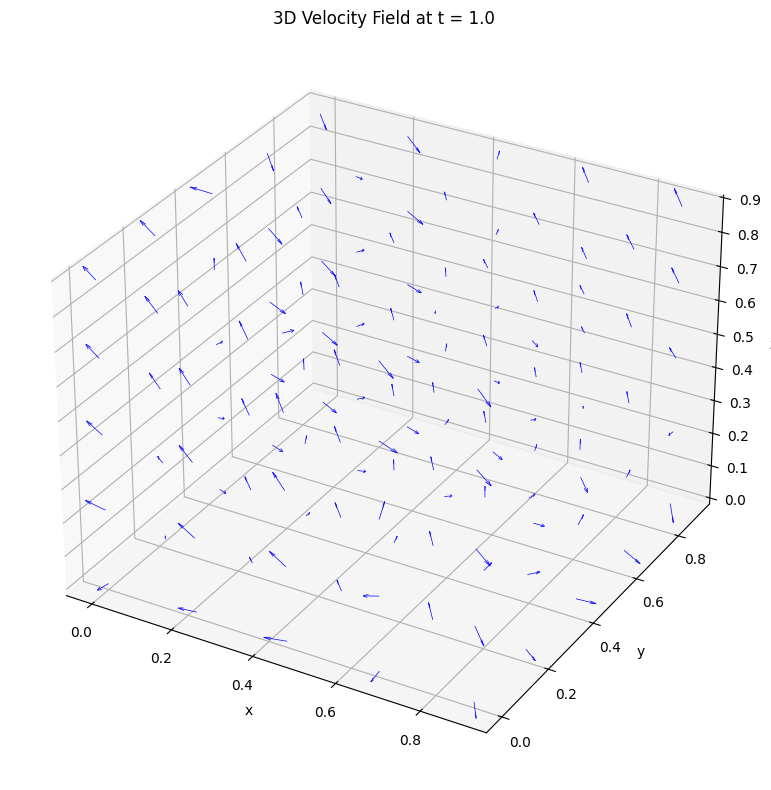

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#Full 3D Visualization of Velocity Field at Fixed Time (Quiver Plot)
# Fix time slice
t_val = 1.0  # You can also loop over multiple time slices

# Create a coarse 3D grid (10x10x10 for visualization purposes)
N = 10
x = torch.linspace(0, 1, N)
y = torch.linspace(0, 1, N)
z = torch.linspace(0, 1, N)
x, y, z = torch.meshgrid(x, y, z, indexing='ij')

x_flat = x.reshape(-1, 1)
y_flat = y.reshape(-1, 1)
z_flat = z.reshape(-1, 1)
t_flat = torch.full_like(x_flat, t_val)

X_test = torch.cat([x_flat, y_flat, z_flat, t_flat], dim=1)

# Evaluate model
model.eval()
with torch.no_grad():
    u_pred = model(X_test).numpy()

u = u_pred[:, 0].reshape(N, N, N)
v = u_pred[:, 1].reshape(N, N, N)
w = u_pred[:, 2].reshape(N, N, N)

# Plotting 3D quiver
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

skip = (slice(None, None, 2), slice(None, None, 2), slice(None, None, 2))  # skip for readability

ax.quiver(
    x[skip].numpy(),
    y[skip].numpy(),
    z[skip].numpy(),
    u[skip],
    v[skip],
    w[skip],
    length=0.05,
    normalize=True,
    color='blue',
    linewidth=0.5
)

ax.set_title(f'3D Velocity Field at t = {t_val}')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.tight_layout()
plt.show()


<ipython-input-5-d526619be9d2>:78: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


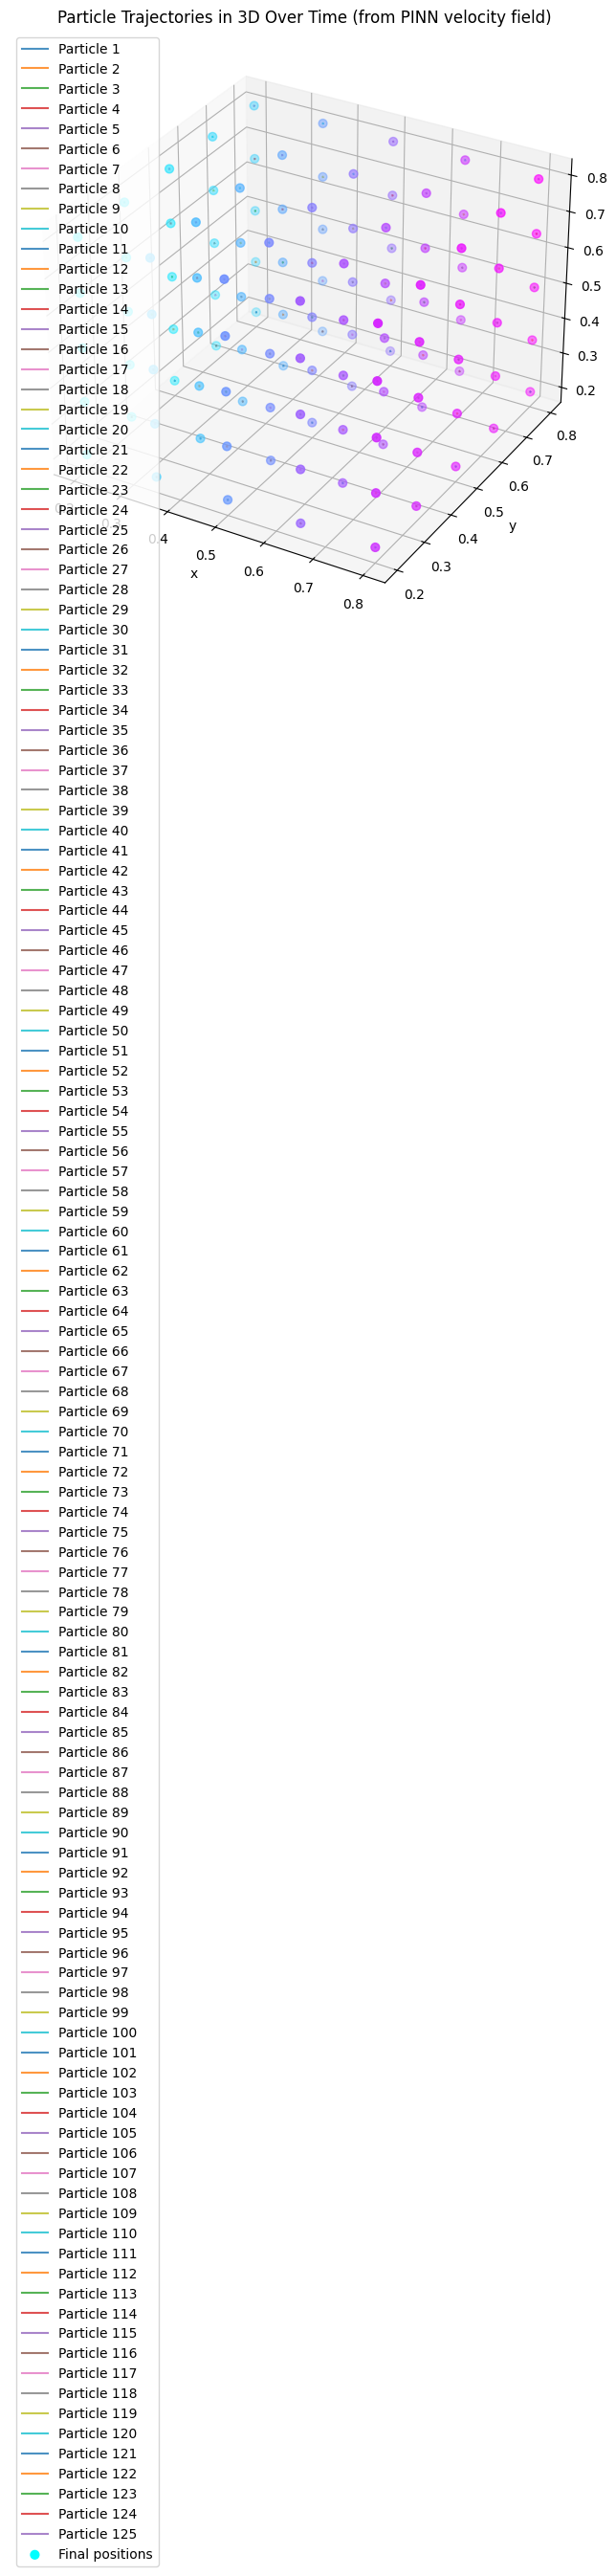

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#Particle Trajectories Over Time Using PINN Velocity Field
# Time setup
T = 1.0
n_steps = 100
dt = T / n_steps
time_points = torch.linspace(0, T, n_steps)

# Initialize a few particles
n_particles = 5
x_init = torch.linspace(0.2, 0.8, n_particles)
y_init = torch.linspace(0.2, 0.8, n_particles)
z_init = torch.linspace(0.2, 0.8, n_particles)

# Mesh grid of initial particle positions
X0, Y0, Z0 = torch.meshgrid(x_init, y_init, z_init, indexing='ij')
X0 = X0.reshape(-1, 1)
Y0 = Y0.reshape(-1, 1)
Z0 = Z0.reshape(-1, 1)

# Total number of particles
N_particles = X0.shape[0]

# Store trajectory
x_traj = [X0]
y_traj = [Y0]
z_traj = [Z0]

x = X0.clone()
y = Y0.clone()
z = Z0.clone()

# Evolve each particle using Euler integration
model.eval()
with torch.no_grad():
    for t in time_points[1:]:
        t_tensor = torch.full_like(x, t)
        input_tensor = torch.cat([x, y, z, t_tensor], dim=1)
        velocity = model(input_tensor)
        u, v, w = velocity[:, 0:1], velocity[:, 1:2], velocity[:, 2:3]

        # Euler integration
        x = x + u * dt
        y = y + v * dt
        z = z + w * dt

        x_traj.append(x.clone())
        y_traj.append(y.clone())
        z_traj.append(z.clone())

# Convert trajectories to numpy arrays
x_traj = torch.stack(x_traj).squeeze().numpy()  # shape: (n_steps, N_particles)
y_traj = torch.stack(y_traj).squeeze().numpy()
z_traj = torch.stack(z_traj).squeeze().numpy()
t_vals = time_points.numpy()

# Plotting trajectories
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i in range(N_particles):
    ax.plot(x_traj[:, i], y_traj[:, i], z_traj[:, i], label=f'Particle {i+1}', alpha=0.8)

# Also mark how x, y, z evolve individually with color coding
scatter = ax.scatter(
    x_traj[-1], y_traj[-1], z_traj[-1],
    c=np.linspace(0, 1, N_particles), cmap='cool', s=40, label='Final positions'
)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Particle Trajectories in 3D Over Time (from PINN velocity field)')
plt.legend()
plt.tight_layout()
plt.show()


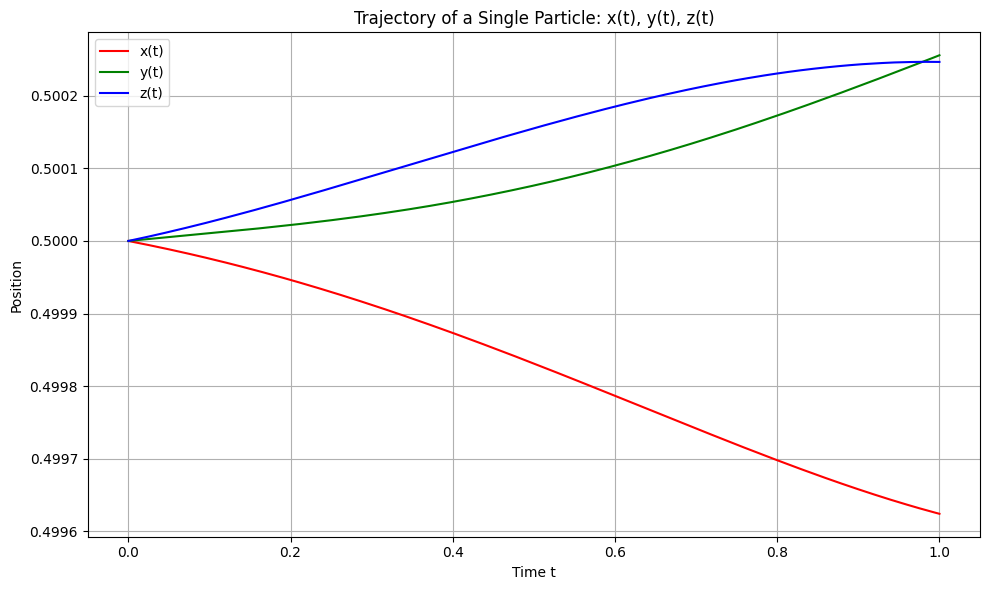

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
#particle trajectoeries over time
# Time setup
T = 1.0
n_steps = 200
dt = T / n_steps
time_points = torch.linspace(0, T, n_steps)

# Initial position of the particle
x = torch.tensor([[0.5]], dtype=torch.float32)
y = torch.tensor([[0.5]], dtype=torch.float32)
z = torch.tensor([[0.5]], dtype=torch.float32)

# Store trajectory
x_vals = [x.item()]
y_vals = [y.item()]
z_vals = [z.item()]
t_vals = [0.0]

# Evolve using Euler integration through the predicted PINN velocity field
model.eval()
with torch.no_grad():
    for t in time_points[1:]:
        t_tensor = torch.full_like(x, t)
        input_tensor = torch.cat([x, y, z, t_tensor], dim=1)
        velocity = model(input_tensor)
        u, v, w = velocity[:, 0:1], velocity[:, 1:2], velocity[:, 2:3]

        # Euler update
        x = x + u * dt
        y = y + v * dt
        z = z + w * dt

        # Store current state
        x_vals.append(x.item())
        y_vals.append(y.item())
        z_vals.append(z.item())
        t_vals.append(t.item())

# Convert to numpy arrays for plotting
x_vals = np.array(x_vals)
y_vals = np.array(y_vals)
z_vals = np.array(z_vals)
t_vals = np.array(t_vals)

# Plot x(t), y(t), z(t)
plt.figure(figsize=(10, 6))
plt.plot(t_vals, x_vals, label='x(t)', color='red')
plt.plot(t_vals, y_vals, label='y(t)', color='green')
plt.plot(t_vals, z_vals, label='z(t)', color='blue')
plt.xlabel('Time t')
plt.ylabel('Position')
plt.title('Trajectory of a Single Particle: x(t), y(t), z(t)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
